
## Identifying Fake Job Postings

This code performs an end to end machine learning model build.

The goal of the model is to detect fake job postings.

The dataset was sourced from Kaggle: https://www.kaggle.com/datasets/shivamb/real-or-fake-fake-jobposting-prediction

Note: This is program #1. It runs the same data cleansing and feature engineering as program #2, but uses one 'across all field' TD-IDF matrix as eligible features to model fitting (less granular and diverse features).

### Library Import and Display Option Settings

In [ ]:
# Import Pandas Library and Set Print / View Options

import pandas as pd

# Set display options
pd.set_option('display.max_columns', None)   # show all columns
pd.set_option('display.width', 200)          # widen the print area
pd.set_option('display.colheader_justify', 'left')  # align headers nicely
pd.set_option('display.max_colwidth', None)  # don't truncate column text

pd.set_option('display.max_rows', None)  # show all rows

### Load and Inspect the Input Dataset

In [ ]:
# Load the Fake Job Postings dataset
from google.colab import drive

drive.mount('/content/drive')

# root_dir is the path to your My_Drive folder.
root_dir = "/content/drive/My Drive/"

# Store the dataframes in the following directory.
data_folder = root_dir + "Colab Notebooks/Applied AI/Final Project/data/"

# the SAV data is at this location
csv_file = "/content/drive/My Drive/Colab Notebooks/Applied AI/Final Project/data/fake_job_postings.csv"

# Read the CSV file into a dataframe named amazon
df = pd.read_csv(csv_file)

# Display info
print(df.info())
df.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15184 non-null  object
 8   benefits             10668 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  1

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaking and award-winning cooking site. We support, connect, and celebrate home cooks, and give them everything they need in one place.We have a top editorial, business, and engineering team. We're focused on using technology to find new and better ways to connect people around their specific food interests, and to offer them superb, highly curated information about food and cooking. We attract the most talented home cooks and contributors in the country; we also publish well-known professionals like Mario Batali, Gwyneth Paltrow, and Danny Meyer. And we have partnerships with Whole Foods Market and Random House.Food52 has been named the best food website by the James Beard Foundation and IACP, and has been featured in the New York Times, NPR, Pando Daily, TechCrunch, and on the Today Show.We're located in Chelsea, in New York City.","Food52, a fast-growing, James Beard Award-winning online food community and crowd-sourced and curated recipe hub, is currently interviewing full- and part-time unpaid interns to work in a small team of editors, executives, and developers in its New York City headquarters.Reproducing and/or repackaging existing Food52 content for a number of partner sites, such as Huffington Post, Yahoo, Buzzfeed, and more in their various content management systemsResearching blogs and websites for the Provisions by Food52 Affiliate ProgramAssisting in day-to-day affiliate program support, such as screening affiliates and assisting in any affiliate inquiriesSupporting with PR &amp; Events when neededHelping with office administrative work, such as filing, mailing, and preparing for meetingsWorking with developers to document bugs and suggest improvements to the siteSupporting the marketing and executive staff","Experience with content management systems a major plus (any blogging counts!)Familiar with the Food52 editorial voice and aestheticLoves food, appreciates the importance of home cooking and cooking with the seasonsMeticulous editor, perfectionist, obsessive attention to detail, maddened by typos and broken links, delighted by finding and fixing themCheerful under pressureExcellent communication skillsA+ multi-tasker and juggler of responsibilities big and smallInterested in and engaged with social media like Twitter, Facebook, and PinterestLoves problem-solving and collaborating to drive Food52 forwardThinks big picture but pitches in on the nitty gritty of running a small company (dishes, shopping, administrative support)Comfortable with the realities of working for a startup: being on call on evenings and weekends, and working long hours",NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production Service.90 Seconds is the worlds Cloud Video Production Service enabling brands and agencies to get high quality online video content shot and produced anywhere in the world. 90 Seconds makes video production fast, affordable, and all managed seamlessly in the cloud from purchase to publish. http://90#URL_fbe6559afac620a3cd2c22281f7b8d0eef56a73e3d9a311e2f1ca13d081dd630#90 Seconds removes the hassle, cost, risk and speed issues of working with regular video production companies by managing every aspect of video projects in a beautiful online experience. With a growing global network of over 2,000 rated video professionals in over 50 countries managed by dedicated production success teams in 5 countries, 90 Seconds provides a 100% success guarantee.90 Seconds has produced almost 4,000 videos in over 30 Countries for over 500 Global brands including some of the worlds largest including Payp

###Missing value counts by column

In [ ]:
# Generate Counts of Null or Missing Values By Columns
print("Null Values By Column, Fake Job Posting Dataset")
df.isnull().sum()

Null Values By Column, Fake Job Posting Dataset


,0
job_id,0
title,0
location,346
department,11547
salary_range,15012
company_profile,3308
description,1
requirements,2696
benefits,7212
telecommuting,0


###Number of Unique Levels By Column

In [ ]:
# Count number of unique levels for each column
levels_count = df.nunique()

print(levels_count)

job_id                 17880
title                  11231
location                3105
department              1337
salary_range             874
company_profile         1709
description            14801
requirements           11967
benefits                6204
telecommuting              2
has_company_logo           2
has_questions              2
employment_type            5
required_experience        7
required_education        13
industry                 131
function                  37
fraudulent                 2
dtype: int64


###Detailed Frequency Distributions of Each Non Text Heavy Field

In [ ]:
# Specify the list of columns for frequency distributions
cols_to_freq = ['location','department','salary_range','telecommuting','has_company_logo','has_questions','employment_type','required_experience','required_education','industry','function','fraudulent']

# Frequency counts for those specific columns
for col in cols_to_freq:
    print(f"\nColumn: {col}")
    print(df[col].value_counts())



Column: location
location
GB, LND, London                                                                                                                                                                                  718
US, NY, New York                                                                                                                                                                                 658
US, CA, San Francisco                                                                                                                                                                            472
GR, I, Athens                                                                                                                                                                                    464
US, ,                                                                                                                                                                                    

###Breaking the Location Field into Parts (For Later Creation of Manageable Features Related to Country)

In [ ]:
# Breaking the Location Field into Parts (Country, State, City)

# Split into 3 separate columns
df[['country', 'state', 'city']] = df['location'].str.split(',', n=2, expand=True)

# Strip whitespace
for col in ['country', 'state', 'city']:
    df[col] = df[col].str.strip()

# Select only the desired columns
subset = df[['location', 'country', 'state', 'city']]

# Print 50 random records
print(subset.sample(n=50, random_state=42))



      location                                          country state city                                    
4708                                       GB, , London   GB                                            London
11079                                US, OH, Cincinnati   US      OH                                Cincinnati
12357                                  US, NY, New York   US      NY                                  New York
14511                                   GB, GBN, London   GB     GBN                                    London
16691                             US, CA, San Francisco   US      CA                             San Francisco
1411                                   US, CA, Campbell   US      CA                                  Campbell
8515                                             IE, ,    IE                                                  
4989                                     US, MN, Duluth   US      MN                                    Duluth
3

### Examining Fraud Incidence By Each Level of the Raw Categorical Fields

In [ ]:
# Pre-selected group of categorical columns
cols_for_fraud_incidence = ['country', 'salary_range','telecommuting','has_company_logo','has_questions','employment_type','required_experience','required_education','industry','function']

# Loop through each categorical column and compute summary
results = {}
for col in cols_for_fraud_incidence:
    summary = df.groupby(col, dropna=False)['fraudulent'].agg(
        count_0=lambda x: (x==0).sum(),
        count_1=lambda x: (x==1).sum(),
        percent_fraud=lambda x: (x==1).mean()*100
    ).reset_index()
    results[col] = summary

# Example: print results for each column
for col, summary in results.items():
    print(f"\nSummary for {col}:")
    print(summary)



Summary for country:
   country  count_0  count_1  percent_fraud
0    AE       53       1       1.851852    
1    AL        1       0       0.000000    
2    AM        2       0       0.000000    
3    AR        9       0       0.000000    
4    AT       14       0       0.000000    
5    AU      174      40      18.691589    
6    BD        2       0       0.000000    
7    BE      117       0       0.000000    
8    BG       17       0       0.000000    
9    BH        4       5      55.555556    
10   BR       35       1       2.777778    
11   BY        9       0       0.000000    
12   CA      445      12       2.625821    
13   CH       15       0       0.000000    
14   CL        2       0       0.000000    
15   CM        1       0       0.000000    
16   CN       15       0       0.000000    
17   CO        1       0       0.000000    
18   CY       11       0       0.000000    
19   CZ        6       0       0.000000    
20   DE      383       0       0.000000    
21   DK   

### Standardizing (Upcase and Space Removal) and Further Collapsing Categorical Fields to Help With Interpretation;  All Levels with < 50 observations Are Grouped into an 'Other' Category Label

In [ ]:
# For Categorical Fields, Assigning Rare Levels to 'Other'

rare_threshold = 50

# Required Education
educ_counts = df['required_education'].value_counts()
educ_rare_levels = educ_counts[educ_counts < rare_threshold].index
df['required_education_grouped'] = (
    df['required_education']
      .replace(educ_rare_levels, 'Other')
      .str.upper()
      .str.replace(" ", "", regex=False)
)


# Country
cty_counts = df['country'].value_counts()
cty_rare_levels = cty_counts[cty_counts < rare_threshold].index
df['country_grouped'] = (
    df['country']
      .replace(educ_rare_levels, 'Other')
      .str.upper()
      .str.replace(" ", "", regex=False)
)

# Employment Type
emp_counts = df['employment_type'].value_counts()
emp_rare_levels = emp_counts[emp_counts < rare_threshold].index
df['employment_type_grouped'] = (
    df['employment_type']
      .replace(educ_rare_levels, 'Other')
      .str.upper()
      .str.replace(" ", "", regex=False)
)


# Required Experience
exper_counts = df['required_experience'].value_counts()
exper_rare_levels = exper_counts[exper_counts < rare_threshold].index
df['required_experience_grouped'] = (
    df['required_experience']
      .replace(educ_rare_levels, 'Other')
      .str.upper()
      .str.replace(" ", "", regex=False)
)

# Industry
indus_counts = df['industry'].value_counts()
indus_rare_levels = indus_counts[indus_counts < rare_threshold].index
df['industry_grouped'] = (
    df['industry']
      .replace(educ_rare_levels, 'Other')
      .str.upper()
      .str.replace(" ", "", regex=False)
)

# Function
func_counts = df['function'].value_counts()
func_rare_levels = func_counts[func_counts < rare_threshold].index
df['function_grouped'] = (
    df['function']
      .replace(educ_rare_levels, 'Other')
      .str.upper()
      .str.replace(" ", "", regex=False)
)


### Examining Fraud Incidence By Each Level of the Standardized and Collapsed Categorical Fields

In [ ]:
# Pre-selected group of categorical columns
cols_for_fraud_incidence = ['country_grouped', 'employment_type_grouped','required_experience_grouped','required_education_grouped','industry_grouped','function_grouped']

# Loop through each categorical column and compute summary
results = {}
for col in cols_for_fraud_incidence:
    summary = df.groupby(col, dropna=False)['fraudulent'].agg(
        count_0=lambda x: (x==0).sum(),
        count_1=lambda x: (x==1).sum(),
        percent_fraud=lambda x: (x==1).mean()*100
    ).reset_index()
    results[col] = summary

# Example: print results for each column
for col, summary in results.items():
    print(f"\nSummary for {col}:")
    print(summary)


Summary for country_grouped:
   country_grouped  count_0  count_1  percent_fraud
0    AE               53       1       1.851852    
1    AL                1       0       0.000000    
2    AM                2       0       0.000000    
3    AR                9       0       0.000000    
4    AT               14       0       0.000000    
5    AU              174      40      18.691589    
6    BD                2       0       0.000000    
7    BE              117       0       0.000000    
8    BG               17       0       0.000000    
9    BH                4       5      55.555556    
10   BR               35       1       2.777778    
11   BY                9       0       0.000000    
12   CA              445      12       2.625821    
13   CH               15       0       0.000000    
14   CL                2       0       0.000000    
15   CM                1       0       0.000000    
16   CN               15       0       0.000000    
17   CO                1       0  

###Performing Frequency/Incidence Based Encoding & Collapsing All the Standardized Categorical Fields Into "High Risk" and "Other" Values Based on Incidence of Fraud at Each Granular Level

In [ ]:
def consolidate_by_fraud(df, cat_col, target_col='fraudulent', threshold=0.10):
    rates = df.groupby(cat_col)[target_col].mean()
    high_risk = rates[rates > threshold].index
    new_col = cat_col + "_by_risk"
    df[new_col] = df[cat_col].apply(lambda x: 'HighRisk' if x in high_risk else 'Other')
    return df

# Apply to multiple categorical variables
categorical_vars = ['country_grouped', 'employment_type_grouped','required_experience_grouped','required_education_grouped','industry_grouped','function_grouped']
for col in categorical_vars:
    df = consolidate_by_fraud(df, col, target_col='fraudulent', threshold=0.10)

# Printing Records Post Consolidation

# Print only selected columns
print(df[['country_grouped_by_risk', 'employment_type_grouped_by_risk','required_experience_grouped_by_risk','required_education_grouped_by_risk','industry_grouped_by_risk','function_grouped_by_risk','fraudulent']].head(10))

  country_grouped_by_risk employment_type_grouped_by_risk required_experience_grouped_by_risk required_education_grouped_by_risk industry_grouped_by_risk function_grouped_by_risk  fraudulent
0  Other                   Other                           Other                               Other                                 Other                 Other                    0         
1  Other                   Other                           Other                               Other                                 Other                 Other                    0         
2  Other                   Other                           Other                               Other                                 Other                 Other                    0         
3  Other                   Other                           Other                               Other                                 Other                 Other                    0         
4  Other                   Other             

### Examining Fraud Incidence By Each Level of the Frequency/Incidence Based Encoded Fields

In [ ]:
# Pre-selected group of categorical columns
cols_for_fraud_incidence = ['country_grouped_by_risk', 'employment_type_grouped_by_risk','required_experience_grouped_by_risk','required_education_grouped_by_risk','industry_grouped_by_risk','function_grouped_by_risk']

# Loop through each categorical column and compute summary
results = {}
for col in cols_for_fraud_incidence:
    summary = df.groupby(col, dropna=False)['fraudulent'].agg(
        count_0=lambda x: (x==0).sum(),
        count_1=lambda x: (x==1).sum(),
        percent_fraud=lambda x: (x==1).mean()*100
    ).reset_index()
    results[col] = summary

# Example: print results for each column
for col, summary in results.items():
    print(f"\nSummary for {col}:")
    print(summary)


Summary for country_grouped_by_risk:
  country_grouped_by_risk  count_0  count_1  percent_fraud
0  HighRisk                  204     65      24.163569    
1     Other                16810    801       4.548294    

Summary for employment_type_grouped_by_risk:
  employment_type_grouped_by_risk  count_0  count_1  percent_fraud
0  Other                           17014    866      4.8434       

Summary for required_experience_grouped_by_risk:
  required_experience_grouped_by_risk  count_0  count_1  percent_fraud
0  Other                               17014    866      4.8434       

Summary for required_education_grouped_by_risk:
  required_education_grouped_by_risk  count_0  count_1  percent_fraud
0  HighRisk                             247     40      13.937282    
1     Other                           16767    826       4.695049    

Summary for industry_grouped_by_risk:
  industry_grouped_by_risk  count_0  count_1  percent_fraud
0  HighRisk                  1312    330      20.097442

###Breaking the Categorical Salary Range Field into Parts and Creating Three Numeric Fields:  Low of the Range, High of the Range, and Difference from High to Low

In [ ]:
# Cleansing and Standardizing the Salary Range Field

# Split into low and high
df[['salary_lowrange', 'salary_highrange']] = df['salary_range'].str.split('-', n=1, expand=True)

# Convert to numeric, coercing errors to NaN. This handles cases where salary_range is NaN,
# or where parts of the split string are not valid numbers.
df['salary_lowrange'] = pd.to_numeric(df['salary_lowrange'], errors='coerce')
df['salary_highrange'] = pd.to_numeric(df['salary_highrange'], errors='coerce')

# Compute difference. Operations involving NaN will result in NaN.
df['salary_range_diff'] = df['salary_highrange'] - df['salary_lowrange']

# Select only the desired columns
subset = df[['salary_range', 'salary_lowrange', 'salary_highrange', 'salary_range_diff']]

# Print 50 random records
print(subset.sample(n=50, random_state=42))

      salary_range     salary_lowrange  salary_highrange  salary_range_diff
4708              NaN       NaN               NaN              NaN         
11079     55000-75000   55000.0           75000.0          20000.0         
12357             NaN       NaN               NaN              NaN         
14511             NaN       NaN               NaN              NaN         
16691             NaN       NaN               NaN              NaN         
1411              NaN       NaN               NaN              NaN         
8515              NaN       NaN               NaN              NaN         
4989              NaN       NaN               NaN              NaN         
361       19000-19000   19000.0           19000.0              0.0         
8250              NaN       NaN               NaN              NaN         
17343             NaN       NaN               NaN              NaN         
5267      60000-90000   60000.0           90000.0          30000.0         
9806        

###Box Plots to Examine Differences in Derived Salary Fields and Fraud Likelihood

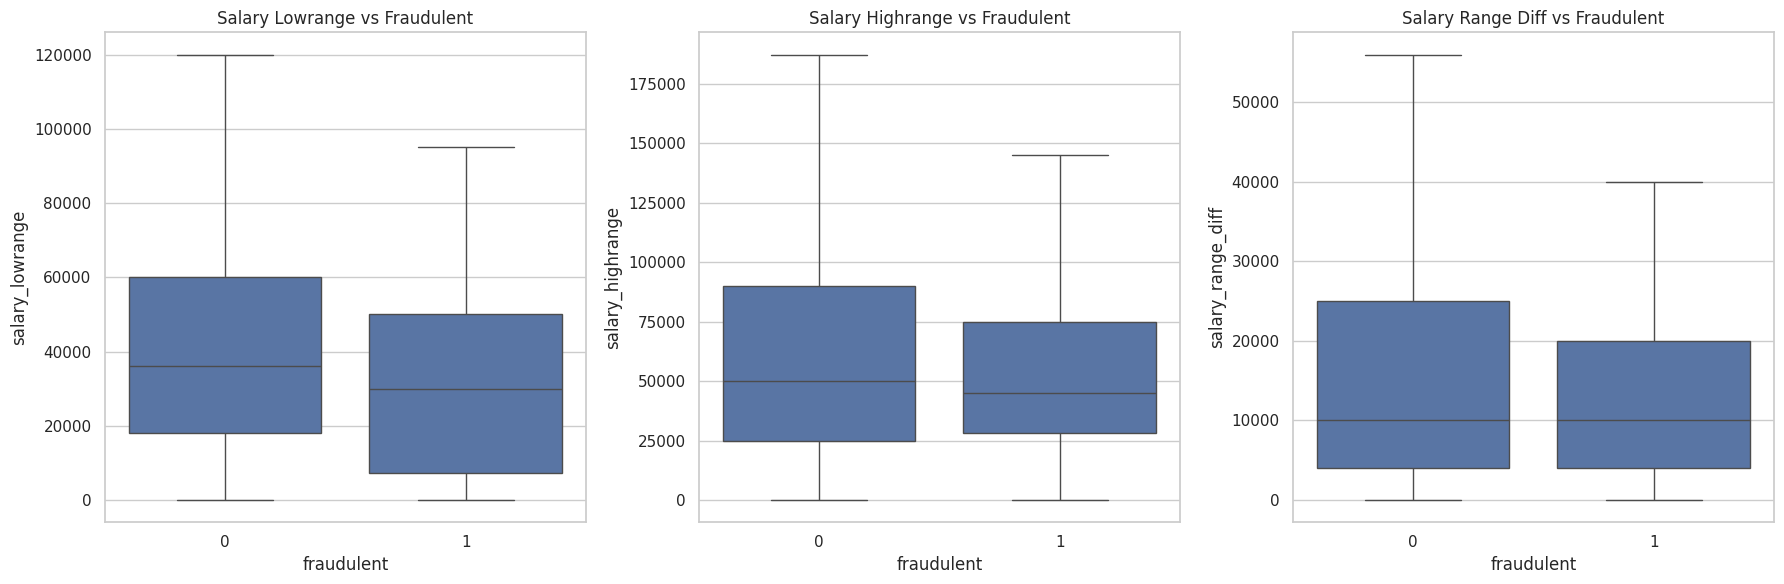

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set style
sns.set(style="whitegrid")

# Create a figure with 3 subplots side by side
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Boxplot for salary_lowrange
sns.boxplot(x='fraudulent', y='salary_lowrange', data=df, showfliers=False, ax=axes[0])
axes[0].set_title('Salary Lowrange vs Fraudulent')

# Boxplot for salary_highrange
sns.boxplot(x='fraudulent', y='salary_highrange', data=df, showfliers=False, ax=axes[1])
axes[1].set_title('Salary Highrange vs Fraudulent')

# Boxplot for salary_range_diff
sns.boxplot(x='fraudulent', y='salary_range_diff', data=df, showfliers=False, ax=axes[2])
axes[2].set_title('Salary Range Diff vs Fraudulent')

plt.tight_layout()
plt.show()


###Creating Buckets of Salary Ranges Based on BoxPlots (Fraudulent Postings Appear to Have Lower Incidence of Low Range Values and the field has a high number of missing values that can be encoded as a stand alone category)

In [ ]:
# --- New code for bucketing ---
def bucket_salary(x):
    if pd.isna(x):
        return 'Missing'
    elif x < 20000:
        return 'Low'
    elif x < 60000:
        return 'Medium'
    else:
        return 'High'

# Apply bucketing to each salary-related field in the main DataFrame
for col in ['salary_lowrange', 'salary_highrange', 'salary_range_diff']:
    df[col + '_bucket'] = df[col].apply(bucket_salary)

# Print 50 random records with buckets from the main DataFrame
print(df[['salary_range', 'salary_lowrange', 'salary_highrange', 'salary_range_diff', 'salary_lowrange_bucket', 'salary_highrange_bucket', 'salary_range_diff_bucket']].sample(n=50, random_state=42))

      salary_range     salary_lowrange  salary_highrange  salary_range_diff salary_lowrange_bucket salary_highrange_bucket salary_range_diff_bucket
4708              NaN       NaN               NaN              NaN           Missing                Missing                 Missing                
11079     55000-75000   55000.0           75000.0          20000.0            Medium                   High                  Medium                
12357             NaN       NaN               NaN              NaN           Missing                Missing                 Missing                
14511             NaN       NaN               NaN              NaN           Missing                Missing                 Missing                
16691             NaN       NaN               NaN              NaN           Missing                Missing                 Missing                
1411              NaN       NaN               NaN              NaN           Missing                Missing     

###Examining Fraud Incidence By Each Level of the Salary Field Buckets

In [ ]:
# Pre-selected group of categorical columns
cols_for_fraud_incidence = ['salary_lowrange_bucket', 'salary_highrange_bucket', 'salary_range_diff_bucket']

# Loop through each categorical column and compute summary
results = {}
for col in cols_for_fraud_incidence:
    summary = df.groupby(col, dropna=False)['fraudulent'].agg(
        count_0=lambda x: (x==0).sum(),
        count_1=lambda x: (x==1).sum(),
        percent_fraud=lambda x: (x==1).mean()*100
    ).reset_index()
    results[col] = summary

# Example: print results for each column
for col, summary in results.items():
    print(f"\nSummary for {col}:")
    print(summary)


Summary for salary_lowrange_bucket:
  salary_lowrange_bucket  count_0  count_1  percent_fraud
0     High                  712     47      6.192358     
1      Low                  717     69      8.778626     
2   Medium                 1212    106      8.042489     
3  Missing                14373    644      4.288473     

Summary for salary_highrange_bucket:
  salary_highrange_bucket  count_0  count_1  percent_fraud
0     High                  1189     89      6.964006     
1      Low                   526     49      8.521739     
2   Medium                   908     85      8.559919     
3  Missing                 14391    643      4.276972     

Summary for salary_range_diff_bucket:
  salary_range_diff_bucket  count_0  count_1  percent_fraud
0     High                    217     28      11.428571    
1      Low                   1609    155       8.786848    
2   Medium                    793     39       4.687500    
3  Missing                  14395    644       4.282200    


###For text-heavy fields, performing TD-IF vectorization to transform raw text into numerical feature representations that capture the importance of words relative to the corpus.


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import numpy as np

# Fill NaN values in text columns with empty strings before TF-IDF vectorization
df['company_profile'] = df['company_profile'].fillna('')
df['description'] = df['description'].fillna('')
df['requirements'] = df['requirements'].fillna('')
df['benefits'] = df['benefits'].fillna('')
df['title'] = df['title'].fillna('')

tfidf_company_profile = TfidfVectorizer(stop_words='english', max_features=50)
X_company_profile = tfidf_company_profile.fit_transform(df['company_profile'])
company_profile_features = [f"company_profile_{w}" for w in tfidf_company_profile.get_feature_names_out()]

tfidf_description = TfidfVectorizer(stop_words='english', max_features=50)
X_description = tfidf_description.fit_transform(df['description'])
description_features = [f"description_{w}" for w in tfidf_description.get_feature_names_out()]

tfidf_requirements = TfidfVectorizer(stop_words='english', max_features=50)
X_requirements = tfidf_requirements.fit_transform(df['requirements'])
requirements_features = [f"requirements_{w}" for w in tfidf_requirements.get_feature_names_out()]


tfidf_benefits = TfidfVectorizer(stop_words='english', max_features=50)
X_benefits = tfidf_benefits.fit_transform(df['benefits'])
benefits_features = [f"benefits_{w}" for w in tfidf_benefits.get_feature_names_out()]

tfidf_title = TfidfVectorizer(stop_words='english', max_features=50)
X_title = tfidf_title.fit_transform(df['title'])
title_features = [f"title_{w}" for w in tfidf_title.get_feature_names_out()]

### Applying TruncatedSVD to the created TD-IDF matrices to reduce the dimensionality of the high-dimensional text vectors while preserving the most informative latent components. By doing so, we mitigate issues of sparsity and multicollinearity, improve computational efficiency, and enable downstream models to focus on the most meaningful textual signals rather than noise from rare or redundant terms.

The reduction below looks across the TD-IDF matrices for each field and consolidates them into a single set of components (i.e., performing the dimension reduction ACROSS all fields)


In [ ]:
# Creating truncated feature set across all TF-IDF matrices.

from sklearn.decomposition import TruncatedSVD
from scipy.sparse import hstack

# Combine all TF-IDF matrices
X_all = hstack([X_title, X_benefits, X_requirements, X_description, X_company_profile])

# Apply TruncatedSVD once
svd = TruncatedSVD(n_components=25, random_state=42)
X_reduced = svd.fit_transform(X_all)

# Create feature names for the SVD components
svd_features = [f"svd_{i}" for i in range(svd.n_components)]


print(X_reduced.shape)  # (n_samples, 25)

# Combine all feature names to match the X_all matrix
all_terms = (
    tfidf_title.get_feature_names_out().tolist() +
    tfidf_benefits.get_feature_names_out().tolist() +
    tfidf_requirements.get_feature_names_out().tolist() +
    tfidf_description.get_feature_names_out().tolist() +
    tfidf_company_profile.get_feature_names_out().tolist()
)

for i, comp in enumerate(svd.components_[:25]):  # All 25 components
    # Get indices of top 10 terms for this component
    top_terms_indices = comp.argsort()[-10:][::-1] # [::-1] to get in descending order of importance
    top_terms = [all_terms[j] for j in top_terms_indices]
    print(f"SVD component {i}: {top_terms}")

(17880, 25)
SVD component 0: ['experience', 'team', 'skills', 'work', 'work', 'manager', 'ability', 'customer', 'years', 'company']
SVD component 1: ['job', 'amp', 'help', 'required', 'preferred', 'english', 'teacher', 'abroad', 'degree', 'experience']
SVD component 2: ['developer', 'engineer', 'design', 'web', 'design', 'web', 'development', 'development', 'software', 'senior']
SVD component 3: ['manager', 'sales', 'sales', 'sales', 'marketing', 'marketing', 'marketing', 'manager', 'business', 'account']
SVD component 4: ['manager', 'job', 'engineer', 'high', 'quality', 'provide', 'companies', 'time', 'manager', 'required']
SVD component 5: ['career', 'time', 'job', 'right', 'time', 'work', 'role', 'job', 'position', 'people']
SVD component 6: ['manager', 'marketing', 'manager', 'marketing', 'marketing', 'career', 'work', 'people', 'right', 'team']
SVD component 7: ['developer', 'sales', 'manager', 'job', 'experience', 'quality', 'sales', 'high', 'provide', 'companies']
SVD component 

###Performing OneHot Encoding Transformations of the Frequency/Incidence Based Encoded Fields and the Salary Bucket Fields

In [ ]:

categorical_features = ['country_grouped_by_risk', 'employment_type_grouped_by_risk','required_experience_grouped_by_risk','required_education_grouped_by_risk','industry_grouped_by_risk','function_grouped_by_risk', 'salary_lowrange_bucket', 'salary_highrange_bucket', 'salary_range_diff_bucket']

# --- Categorical features ---
onehot = OneHotEncoder(handle_unknown='ignore')
X_cat = onehot.fit_transform(df[categorical_features])

# Get feature names with prefixes from each column
cat_features = onehot.get_feature_names_out(categorical_features)

print(cat_features[:40])  # show first 40 encoded feature names




['country_grouped_by_risk_HighRisk' 'country_grouped_by_risk_Other'
 'employment_type_grouped_by_risk_Other'
 'required_experience_grouped_by_risk_Other'
 'required_education_grouped_by_risk_HighRisk'
 'required_education_grouped_by_risk_Other'
 'industry_grouped_by_risk_HighRisk' 'industry_grouped_by_risk_Other'
 'function_grouped_by_risk_HighRisk' 'function_grouped_by_risk_Other'
 'salary_lowrange_bucket_High' 'salary_lowrange_bucket_Low'
 'salary_lowrange_bucket_Medium' 'salary_lowrange_bucket_Missing'
 'salary_highrange_bucket_High' 'salary_highrange_bucket_Low'
 'salary_highrange_bucket_Medium' 'salary_highrange_bucket_Missing'
 'salary_range_diff_bucket_High' 'salary_range_diff_bucket_Low'
 'salary_range_diff_bucket_Medium' 'salary_range_diff_bucket_Missing']


###Defining Eilgible Binary Features and their Labels For Downstream Model Interpreatation

In [ ]:
from scipy.sparse import csc_matrix

# Extract binary features
binary_cols = ['telecommuting', 'has_company_logo', 'has_questions']
X_binary_features = df[binary_cols].values
X_binary_sparse = csc_matrix(X_binary_features)

# Keep track of feature names
binary_feature_names = binary_cols

###With Feature Engineering and Reduction Complete, Fitting Baseline Logisitic Model

Baseline Model Fit #1:   Logistic with Detailed, All-Field 'Combined' Latent SVD Variables As Eligible Features

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    average_precision_score
)
from sklearn.utils.class_weight import compute_class_weight
from scipy.sparse import hstack, csc_matrix

# --- Example target ---
y = df['fraudulent']

# Ensure X_binary_features is a sparse matrix for hstack
X_binary_features_sparse = csc_matrix(df[binary_cols].values)

X = hstack([X_reduced, X_cat, X_binary_features_sparse])

# Correct concatenation of feature names: convert cat_features to list
feature_names = svd_features + cat_features.tolist() + binary_feature_names

# --- Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# --- Compute class weights for imbalance ---
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))
print("Class weights:", class_weights)

# --- Logistic Regression with class weights ---
clf = LogisticRegression(
    penalty='l2',          # LBFGS supports L2
    solver='lbfgs',
    max_iter=5000,
    class_weight='balanced'  # or your computed dictionary
)

clf.fit(X_train, y_train)

# --- Predictions on test set ---
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]

# --- Fit statistics ---
print("Accuracy (test):", accuracy_score(y_test, y_pred))
print("\nClassification Report (test):\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix (test):\n", confusion_matrix(y_test, y_pred))
print("ROC-AUC (test):", roc_auc_score(y_test, y_prob))
print("PR-AUC (test):", average_precision_score(y_test, y_prob))


Class weights: {np.int64(0): np.float64(0.52544080604534), np.int64(1): np.float64(10.326732673267326)}
Accuracy (test): 0.8284862043251305

Classification Report (test):
               precision    recall  f1-score   support

           0       0.99      0.83      0.90      5104
           1       0.20      0.88      0.33       260

    accuracy                           0.83      5364
   macro avg       0.60      0.85      0.62      5364
weighted avg       0.95      0.83      0.87      5364


Confusion Matrix (test):
 [[4215  889]
 [  31  229]]
ROC-AUC (test): 0.9136356100795757
PR-AUC (test): 0.43880836915400506


Baseline Model Fit #1: Logistic with Detailed, All-Field 'Combined' Latent SVD Variables As Eligible Features:

Examining Precision-Recall Curve and Finding "Best" Threshold Value that Balances the trade-off between precision (minimizing false positives) and recall (capturing as many true fraud cases as possible). By plotting the precision-recall curve on the test set, we can visualize how different probability thresholds affect model performance. The "best" threshold is not necessarily 0.5; instead, it is chosen based on business priorities
(e.g., maximizing fraud detection while keeping false alarms manageable). This threshold can be identified by calculating the F1-score or another custom metric across all possible cutoffs, then selecting the point that
optimizes the desired balance. Once determined, this threshold is applied to convert predicted probabilities into binary fraud/non-fraud classifications, ensuring the model aligns with operational goals.


Best threshold: 0.859
Precision: 0.504, Recall: 0.504, F1: 0.504


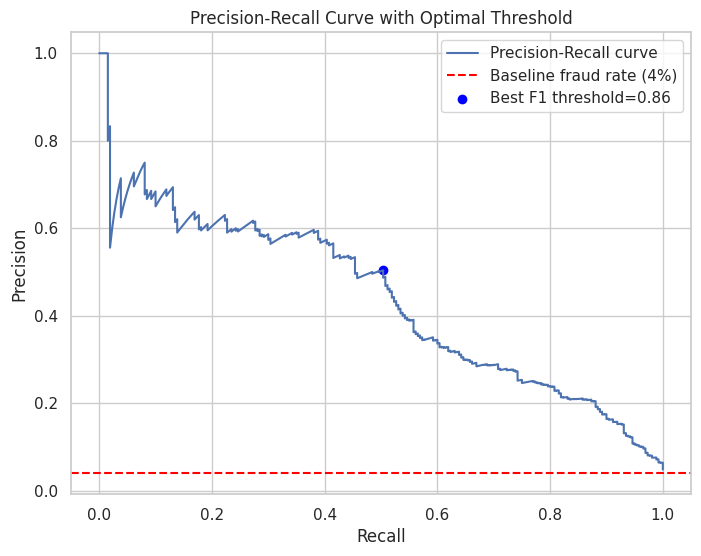

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, f1_score
import numpy as np

# Compute precision, recall, thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

# Compute F1 for each threshold
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)

# Find threshold that maximizes F1
best_index = np.argmax(f1_scores)
best_threshold = thresholds[best_index]
best_f1 = f1_scores[best_index]

print(f"Best threshold: {best_threshold:.3f}")
print(f"Precision: {precision[best_index]:.3f}, Recall: {recall[best_index]:.3f}, F1: {best_f1:.3f}")

# Plot precision-recall curve
plt.figure(figsize=(8,6))
plt.plot(recall, precision, label="Precision-Recall curve")
plt.axhline(y=0.04, color='red', linestyle='--', label="Baseline fraud rate (4%)")
plt.scatter(recall[best_index], precision[best_index], color='blue', label=f"Best F1 threshold={best_threshold:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve with Optimal Threshold")
plt.legend()
plt.show()

Baseline Model Fit #1: Logistic with Detailed, All-Field 'Combined' Latent SVD Variables As Eligible Features

Applying Optimal Cutoff Threshold and Regenerating Model Fit Statistics

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, average_precision_score

# --- Assume you already have ---
# y_test = true labels
# y_prob = predicted probabilities from clf.predict_proba(X_test)[:, 1]

best_threshold = 0.859

# Apply threshold to probabilities
y_pred_threshold = (y_prob >= best_threshold).astype(int)

# --- Recreate fit statistics with new threshold ---
print(f"Using threshold = {best_threshold:.3f}")
print("Accuracy (test):", accuracy_score(y_test, y_pred_threshold))
print("\nClassification Report (test):\n", classification_report(y_test, y_pred_threshold))
print("\nConfusion Matrix (test):\n", confusion_matrix(y_test, y_pred_threshold))
print("ROC-AUC (test):", roc_auc_score(y_test, y_prob))
print("PR-AUC (test):", average_precision_score(y_test, y_prob))



Using threshold = 0.859
Accuracy (test): 0.9517151379567487

Classification Report (test):
               precision    recall  f1-score   support

           0       0.97      0.97      0.97      5104
           1       0.50      0.50      0.50       260

    accuracy                           0.95      5364
   macro avg       0.74      0.74      0.74      5364
weighted avg       0.95      0.95      0.95      5364


Confusion Matrix (test):
 [[4975  129]
 [ 130  130]]
ROC-AUC (test): 0.9136356100795757
PR-AUC (test): 0.43880836915400506


Baseline Model Fit #1: Logistic with Detailed, All-Field 'Combined' Latent SVD Variables As Eligible Features  

Displaying Feature Direction and Importance For Top 20 Features

In [ ]:
coefs = clf.coef_[0]

# --- Create DataFrame of coefficients ---
coef_df = pd.DataFrame({
    "feature": feature_names,
    "coefficient": coefs,
    "abs_coefficient": np.abs(coefs)
})

# --- Sort by absolute importance ---
coef_df = coef_df.sort_values("abs_coefficient", ascending=False)

# --- Display top 20 most important features ---
print(coef_df.head(20))

   feature                             coefficient  abs_coefficient
23                             svd_23  2.951754     2.951754       
5                               svd_5 -2.666477     2.666477       
9                               svd_9 -2.447909     2.447909       
7                               svd_7 -2.338948     2.338948       
0                               svd_0 -2.229604     2.229604       
16                             svd_16 -1.854924     1.854924       
21                             svd_21 -1.739538     1.739538       
48                   has_company_logo -1.725159     1.725159       
17                             svd_17  1.593000     1.593000       
38     salary_lowrange_bucket_Missing  1.510891     1.510891       
15                             svd_15  1.334732     1.334732       
10                             svd_10 -1.192939     1.192939       
31  industry_grouped_by_risk_HighRisk  1.129093     1.129093       
25   country_grouped_by_risk_HighRisk  1.033085 

Baseline Model Fit #1: Logistic with Detailed, All-Field 'Combined' Latent SVD Variables As Eligible Features  

Plotting Top 20 Feature Importance

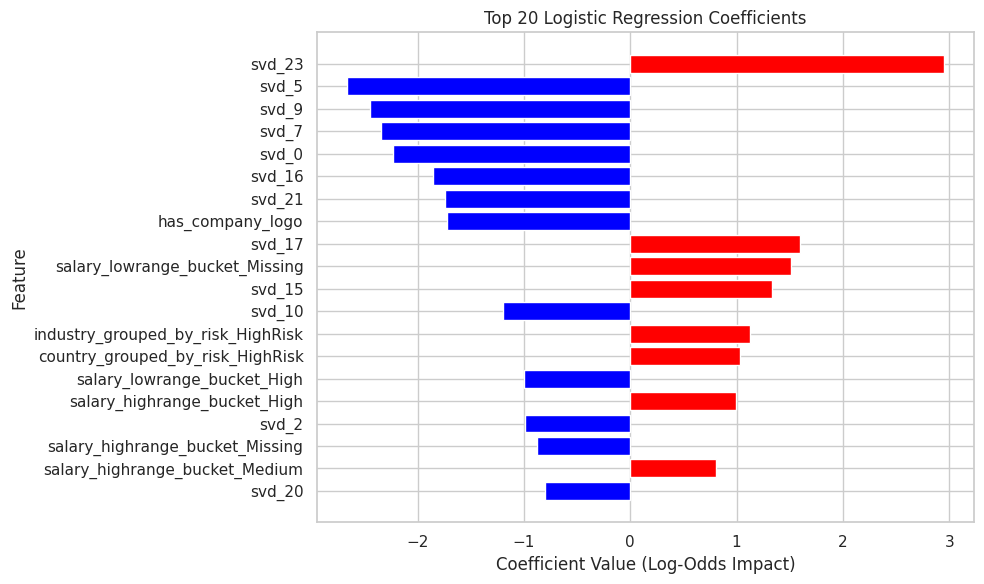

In [ ]:
import matplotlib.pyplot as plt

# --- Assume coef_df is already created as in your code ---
# It has columns: 'feature', 'coefficient', 'abs_coefficient'

# Select top 20 by absolute coefficient
top_features = coef_df.sort_values("abs_coefficient", ascending=False).head(20)

# Colors: red for positive, blue for negative
colors = top_features['coefficient'].apply(lambda x: 'red' if x > 0 else 'blue')

# Plot
plt.figure(figsize=(10, 6))
plt.barh(top_features['feature'], top_features['coefficient'], color=colors)
plt.xlabel("Coefficient Value (Log-Odds Impact)")
plt.ylabel("Feature")
plt.title("Top 20 Logistic Regression Coefficients")
plt.gca().invert_yaxis()  # largest at top
plt.tight_layout()
plt.show()


###Challenger Model #1a: Random Forest Using the Across Fields SVD-reduced feature set

CV GridSearch to Identify Optimal Combination of Number of Estimators (e.g., Trees) and Max Tree Depth

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    precision_recall_curve,
    auc
)

from sklearn.model_selection import GridSearchCV

# Define parameter grid with only two knobs
param_grid = {
    'n_estimators': [50, 100, 150, 200],   # number of trees
    'max_depth': [5, 10, 20, 30]    # tree depth
}

# Initialize model
rf = RandomForestClassifier(
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)

# Grid search with cross-validation
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='roc_auc',   # or 'average_precision' for PR-AUC
    cv=5,
    verbose=2,
    n_jobs=-1
)

# Fit on training data
grid_search.fit(X_train, y_train)

# Best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best CV score:", grid_search.best_score_)


Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters: {'max_depth': 30, 'n_estimators': 200}
Best CV score: 0.9549692854017012


Challenger Model #1a: Random Forest Using the Across Fields SVD-reduced feature set

Fitting the model with the tuning parameters identified via the CVGridSearch

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    precision_recall_curve,
    auc
)

# --- Random Forest Challenger ---
rf_clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=30,
    random_state=42,
    class_weight='balanced',   # handle imbalance
    n_jobs=-1
)

rf_clf.fit(X_train, y_train)
rf_pred = rf_clf.predict(X_test)
rf_prob = rf_clf.predict_proba(X_test)[:, 1]

print("\n--- Random Forest Results ---")
print("Accuracy (test):", accuracy_score(y_test, rf_pred))
print("\nClassification Report (test):\n", classification_report(y_test, rf_pred))
print("\nConfusion Matrix (test):\n", confusion_matrix(y_test, rf_pred))
print("ROC-AUC (test):", roc_auc_score(y_test, rf_prob))

# PR-AUC

precision, recall, _ = precision_recall_curve(y_test, rf_prob)
print("PR-AUC (test):", auc(recall, precision))



--- Random Forest Results ---
Accuracy (test): 0.9703579418344519

Classification Report (test):
               precision    recall  f1-score   support

           0       0.97      1.00      0.98      5104
           1       0.98      0.40      0.56       260

    accuracy                           0.97      5364
   macro avg       0.98      0.70      0.77      5364
weighted avg       0.97      0.97      0.96      5364


Confusion Matrix (test):
 [[5102    2]
 [ 157  103]]
ROC-AUC (test): 0.979385323727996
PR-AUC (test): 0.8243432473563452


Challenger Model #1a: Random Forest Using the Across Fields SVD-reduced feature set

Examining Precision-Recall Curve and Finding "Best" Threshold Value that Balances the trade-off between precision (minimizing false positives) and recall (capturing as many true fraud cases as possible).  Need to calibrate the predicted probabilites first for both random forest and xgboost to calculate accurate threshold.

In [ ]:
from sklearn.calibration import CalibratedClassifierCV

rf_cal = CalibratedClassifierCV(rf_clf, method='isotonic', cv=5)
rf_cal.fit(X_train, y_train)
y_prob_cal = rf_cal.predict_proba(X_test)[:, 1]


In [ ]:
import numpy as np
from sklearn.metrics import f1_score, precision_recall_curve

# y_test = true labels
# y_prob = predicted probabilities from rf_clf.predict_proba(X_test)[:, 1]

# Define candidate thresholds (you can use the PR curve thresholds or a linspace)
thresholds = np.linspace(0, 1, 200)
f1_scores = []

for t in thresholds:
    y_pred = (y_prob_cal >= t).astype(int)   # <-- use calibrated probs
    f1_scores.append(f1_score(y_test, y_pred, pos_label=1))

best_index = np.argmax(f1_scores)
best_threshold = thresholds[best_index]
best_f1 = f1_scores[best_index]

print(f"Best threshold: {best_threshold:.3f}")
print(f"Best F1: {best_f1:.3f}")


Best threshold: 0.276
Best F1: 0.739


Challenger Model #1a: Random Forest Using the Across Fields SVD-reduced feature set

Applying Optimal Cutoff Threshold and Regenerating Model Fit Statistics

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, average_precision_score

# --- Assume you already have ---
# y_test = true labels
# y_prob = predicted probabilities from rf_clf.predict_proba(X_test)[:, 1]

best_threshold = 0.276   # <-- use your optimal threshold

# Apply threshold to probabilities
y_pred_threshold = (y_prob_cal >= best_threshold).astype(int)

# Recreate fit statistics
print(f"Using threshold = {best_threshold:.3f}")
print("Accuracy (test):", accuracy_score(y_test, y_pred_threshold))
print("\nClassification Report (test):\n", classification_report(y_test, y_pred_threshold))
print("\nConfusion Matrix (test):\n", confusion_matrix(y_test, y_pred_threshold))
print("ROC-AUC (test):", roc_auc_score(y_test, y_prob_cal))   # unchanged
print("PR-AUC (test):", average_precision_score(y_test, y_prob_cal))  # unchanged


Using threshold = 0.276
Accuracy (test): 0.9753914988814317

Classification Report (test):
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      5104
           1       0.76      0.71      0.74       260

    accuracy                           0.98      5364
   macro avg       0.87      0.85      0.86      5364
weighted avg       0.97      0.98      0.97      5364


Confusion Matrix (test):
 [[5047   57]
 [  75  185]]
ROC-AUC (test): 0.9791411713286713
PR-AUC (test): 0.821138406121504


Challenger Model #1a: Random Forest Using the Across Fields SVD-reduced feature set

Creating SHAP values and chart to provide feature importance

SHAP values shape: (5364, 50)
X_test shape (dense conversion for SHAP): (5364, 50)


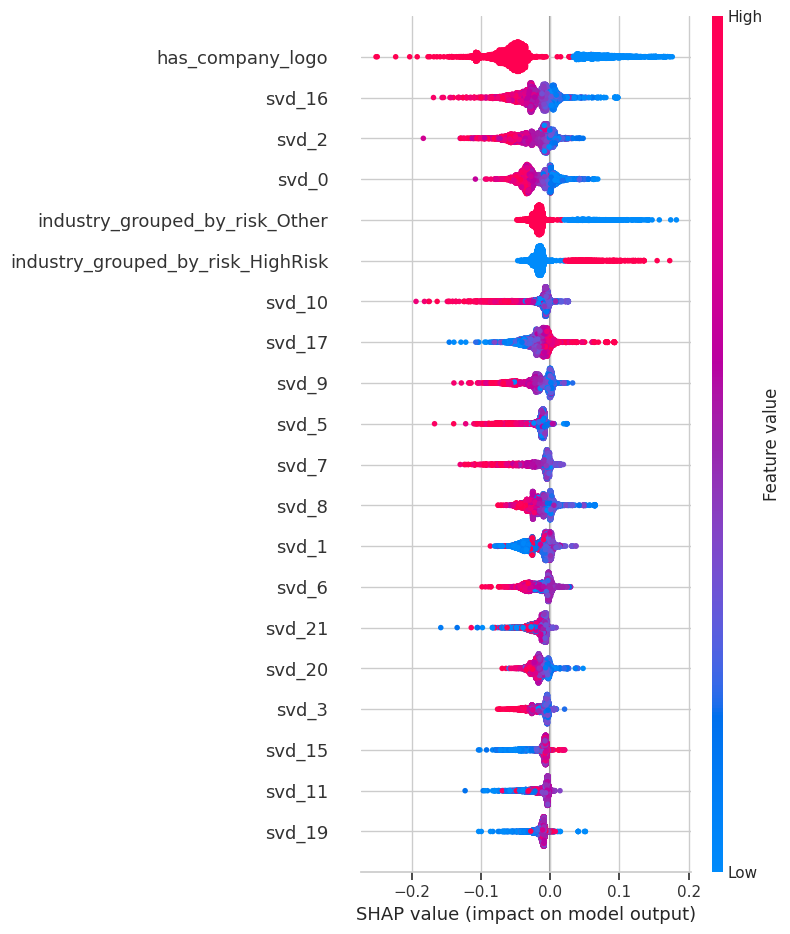

In [ ]:
import shap
import matplotlib.pyplot as plt

# 2. Create SHAP explainer
explainer = shap.TreeExplainer(rf_clf)

# 3. Compute SHAP values on the full test set
# Important: use the same representation (dense vs sparse) that you trained on
# Convert X_test to a dense array as SHAP explainer expects dense input for some internal operations
shap_values = explainer.shap_values(X_test.toarray())

# 4. Check shapes
print("SHAP values shape:", shap_values[:, :, 1].shape)  # should be (n_samples, n_features)
print("X_test shape (dense conversion for SHAP):", X_test.toarray().shape)               # should match

# 5. Global feature importance plot
# Use shap_values[:, :, 1] to get SHAP values for class 1 across all samples
shap.summary_plot(shap_values[:, :, 1], X_test.toarray(), feature_names=feature_names)


###Challenger Model #2a: XGBoost Using the Across Fields SVD-reduced feature set

CV GridSearch to Identify Optimal Combination of Number of Estimators (e.g., Trees) and Max Tree Depth

In [ ]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    precision_recall_curve,
    auc
)
from sklearn.model_selection import GridSearchCV

# Define parameter grid for XGBoost
param_grid = {
    'n_estimators': [50, 100, 150, 200],   # number of boosting rounds
    'max_depth': [5, 10, 20, 30],          # tree depth
    'learning_rate': [0.01, 0.1, 0.2],     # step size shrinkage
    'subsample': [0.8, 1.0],               # row sampling
    'colsample_bytree': [0.8, 1.0]         # feature sampling
}

# Initialize XGBoost model
xgb = XGBClassifier(
    random_state=42,
    n_jobs=-1,
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=(len(y_train[y_train==0]) / len(y_train[y_train==1]))  # handle imbalance
)

# Grid search with cross-validation
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='roc_auc',   # or 'average_precision' for PR-AUC
    cv=5,
    verbose=2,
    n_jobs=-1
)

# Fit on training data
grid_search.fit(X_train, y_train)

# Best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best CV score:", grid_search.best_score_)

Fitting 5 folds for each of 192 candidates, totalling 960 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [01:55:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 30, 'n_estimators': 200, 'subsample': 0.8}
Best CV score: 0.9548554273567131


Challenger Model #2a: XGBoost Using the Across Fields SVD-reduced feature set

Fitting the model with the tuning parameters identified via the CVGridSearch

In [ ]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    precision_recall_curve,
    auc
)

# Calculate imbalance ratio
neg, pos = np.bincount(y_train)
scale_pos_weight = neg / pos

# --- XGBoost Challenger ---
xgb_clf = XGBClassifier(
    n_estimators=200,
    max_depth=30,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight   # <-- imbalance handling here
)

# Fit the model
xgb_clf.fit(X_train, y_train)

# Predictions
xgb_pred = xgb_clf.predict(X_test)
xgb_prob = xgb_clf.predict_proba(X_test)[:, 1]

print("\n--- XGBoost Results ---")
print("Accuracy (test):", accuracy_score(y_test, xgb_pred))
print("\nClassification Report (test):\n", classification_report(y_test, xgb_pred))
print("\nConfusion Matrix (test):\n", confusion_matrix(y_test, xgb_pred))
print("ROC-AUC (test):", roc_auc_score(y_test, xgb_prob))

# PR-AUC
precision, recall, _ = precision_recall_curve(y_test, xgb_prob)
print("PR-AUC (test):", auc(recall, precision))


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [02:42:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- XGBoost Results ---
Accuracy (test): 0.9778150633855331

Classification Report (test):
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      5104
           1       0.89      0.62      0.73       260

    accuracy                           0.98      5364
   macro avg       0.93      0.81      0.86      5364
weighted avg       0.98      0.98      0.98      5364


Confusion Matrix (test):
 [[5083   21]
 [  98  162]]
ROC-AUC (test): 0.9778695442488546
PR-AUC (test): 0.834835625863461


Challenger Model #2a: XGBoost Using the Across Fields SVD-reduced feature set

Examining Precision-Recall Curve and Finding "Best" Threshold Value that Balances the trade-off between precision (minimizing false positives) and recall (capturing as many true fraud cases as possible).  Need to calibrate the predicted probabilites first for both random forest and xgboost to calculate accurate threshold.

In [ ]:
from sklearn.calibration import CalibratedClassifierCV

xgb_cal = CalibratedClassifierCV(xgb_clf, method='isotonic', cv=5)
xgb_cal.fit(X_train, y_train)

# --- Get calibrated probabilities ---
y_prob_cal = xgb_cal.predict_proba(X_test)[:, 1]


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [02:42:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [02:42:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [02:42:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [02:43:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [02:43:03] WARNING: /w

In [ ]:
import numpy as np
from sklearn.metrics import f1_score

# y_test = true labels
# y_prob = predicted probabilities from XGBClassifier
# y_prob = xgb_clf.predict_proba(X_test)[:, 1]   # same as Random Forest

thresholds = np.linspace(0, 1, 200)
f1_scores = []

for t in thresholds:
    y_pred = (y_prob_cal >= t).astype(int)
    f1_scores.append(f1_score(y_test, y_pred, pos_label=1))

best_index = np.argmax(f1_scores)
best_threshold = thresholds[best_index]
best_f1 = f1_scores[best_index]

print(f"Best threshold: {best_threshold:.3f}")
print(f"Best F1: {best_f1:.3f}")

Best threshold: 0.296
Best F1: 0.763


Challenger Model #2a: XGBoost Using the Across Fields SVD-reduced feature set

Applying Optimal Cutoff Threshold and Regenerating Model Fit Statistics

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, average_precision_score

# --- Assume you already have ---
# y_test = true labels
# y_prob = predicted probabilities from xgb_clf.predict_proba(X_test)[:, 1]

best_threshold = 0.296   # <-- use your optimal threshold

# Apply threshold to probabilities
y_pred_threshold = (y_prob_cal >= best_threshold).astype(int)

# Recreate fit statistics
print(f"Using threshold = {best_threshold:.3f}")
print("Accuracy (test):", accuracy_score(y_test, y_pred_threshold))
print("\nClassification Report (test):\n", classification_report(y_test, y_pred_threshold))
print("\nConfusion Matrix (test):\n", confusion_matrix(y_test, y_pred_threshold))
print("ROC-AUC (test):", roc_auc_score(y_test, y_prob_cal))   # unchanged, uses raw probabilities
print("PR-AUC (test):", average_precision_score(y_test, y_prob_cal))  # unchanged, uses raw probabilities


Using threshold = 0.296
Accuracy (test): 0.9778150633855331

Classification Report (test):
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      5104
           1       0.79      0.74      0.76       260

    accuracy                           0.98      5364
   macro avg       0.89      0.86      0.88      5364
weighted avg       0.98      0.98      0.98      5364


Confusion Matrix (test):
 [[5053   51]
 [  68  192]]
ROC-AUC (test): 0.9772037768266215
PR-AUC (test): 0.8342288289832339


Challenger Model #2a: XGBoost Using the Across Fields SVD-reduced feature set

Creating SHAP values and chart to provide feature importance

SHAP values shape: (5364, 50)
X_test shape (dense conversion for SHAP): (5364, 50)


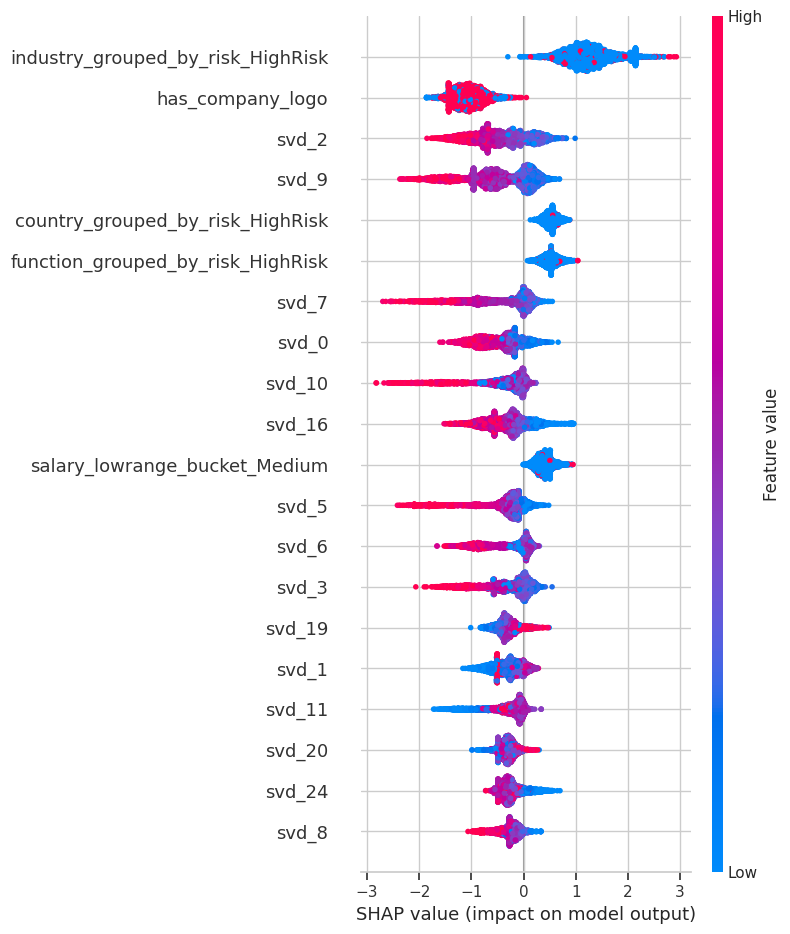

In [ ]:
import shap
import matplotlib.pyplot as plt

# 1. Create SHAP explainer for XGBoost
explainer = shap.TreeExplainer(xgb_clf)

# 2. Compute SHAP values on the full test set
# Important: use the same representation (dense vs sparse) that you trained on
# If you trained on dense arrays, convert here too
X_test_dense = X_test.toarray()   # only if X_test is sparse
shap_values = explainer.shap_values(X_test_dense)

# 3. Check shapes
# For XGBoost, shap_values is typically a 2D array (n_samples, n_features)
# If it were a list (e.g., from some multi-output models), shap_values[1] might be used for the positive class.
print("SHAP values shape:", shap_values.shape) # Use .shape directly as it's a 2D array
print("X_test shape (dense conversion for SHAP):", X_test_dense.shape)

# 4. Global feature importance plot
# Pass the 2D shap_values directly
shap.summary_plot(shap_values, X_test_dense, feature_names=feature_names)